In [35]:
# Imports
import json, re, numpy as np, numpy.linalg as nplin, matplotlib.pyplot as plt, matplotlib.mlab as mlab, scipy.stats as spstat
import pickle, urllib2
from __future__ import division
from operator import itemgetter
from time import time
%matplotlib inline

sc

In [36]:
# Functions to get precision recall curves, given by instructor
def prcurve(ranking, positives, curvetitle):
    """
    Display the precision-recall curve and 
    compute the area under it. (See `prcurve_1` and `prcurve_2`.)
    """

    # Change ID formats
    mapping = pickle.load(urllib2.urlopen("https://s3.amazonaws.com/ml-lightcurves-q14/mapp.pickle"))
    as_dict = dict([(y, x) for (x, y) in mapping])
    ranking = [as_dict.get(x, None) for x in ranking]
    as_dict = None
    mapping = None

    # Precision-recall
    precision = []
    recall = []
    count = 0.0
    N = len(positives)
    for i, ID in enumerate(ranking):
        if ID in positives:
            count += 1.0
            precision.append( count/(i+1) )
            recall.append( count/ N )
        if count == N:
            break

    a = np.array(precision, dtype=np.float32)
    area = np.sum(a / N)

    plt.plot(recall, precision, '-r', linewidth=2)
    plt.xlabel('recall', fontsize=15)
    plt.ylabel('precision',fontsize=15)
    plt.xlim((-0.01,1.01))
    plt.title('{} area = {}'.format(curvetitle, area), fontsize=15)
    plt.show()

    return area

def prcurve_1(ranking):
    """
    PART I: detect confirmed or eclipsing binary stars
    """
    conf_and_eb_id = [int(i) for i in 
                      urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_and_eb_id.txt')]
    conf_cand_eb_id = [int(i) for i in
                       urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_cand_eb_id.txt')]
    
    return (prcurve(ranking, conf_and_eb_id, "conf+eb"),
            prcurve(ranking, conf_cand_eb_id, "conf&cand+eb"))

def prcurve_2(ranking):
    """
    PART II: detect confirmed stars
    """
    conf_id = [int(i) for i in 
               urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_id.txt')]
    conf_and_cand_id = [int(i) for i in 
                        urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_and_cand_id.txt')]
    
    return (prcurve(ranking, conf_id, "conf"),
            prcurve(ranking, conf_and_cand_id, "conf&cand"))

In [6]:
# Parse and load data
def parse(a):
    time = np.array(a['data'][0:4757])
    flux = np.array(a['data'][4757:])
    return (a['id'],time, flux)

##### ADD THE ID VARIABLE IN
lc = sc.textFile("s3n://stat-37601/lightcurves.json",40)\
    .map(json.loads)\
    .filter(lambda js: len(js['data'])==4757*2)\
    .map(parse)\
    .cache()

In [7]:
# Check everything makes sense
print '%d observations spread over %d partitions' % (lc.count(),lc.getNumPartitions())

166903 observations spread over 40 partitions


### PART I. DETECTING TRANSITS AND ECLIPSING BINARY STARS

#### (a) Fit the light curve using Nadaraya-Watson kernel estimator & (b) compute the residual
I'm testing my functions here. parts (a)-(e) will run together at the end of PART 1

In [11]:
# I'm using the Epanechnikov kernel because it's smooth and has compact support
# Could also use the Tricube, though it tends not to make much difference
def epanechinkov(u):
    '''Evaluates the epanechinkov kernel for each value of a numpy array'''
    # It seems like subsetting the data first should be quickest
    return (1 - u*u) * (abs(u) <=1)

# For cross validation, the squared error is going to heavily penalize outliers (which are exactly what we don't want to smooth over)
# These are a series of alternate loss functions I'm trying
def hubber_loss(res,c=100):
    '''Calculates the hubber loss function for a residual vector and given c value'''
    hb = np.empty(len(res))
    above = np.abs(res)>c
    below = np.logical_not(above)
    hb[below] = res[below]**2/2
    hb[above] =          c**2/2 + c*np.abs(res[above])
    return hb

def trimmed_loss(res,q=80):
    '''Calculates the trimmed loss, which is the squared residuals excluding the most extreme residuals'''
    percentile = np.percentile(res,q)
    hb = np.where(res<percentile,res**2,0)
    return hb

def sqrd_loss(res):
    '''Squared loss'''
    return res**2

def abs_loss(res):
    '''Absolute Loss'''
    return np.abs(res)

# The Kernel_regression. The Ws will be passed in.
def generate_w(bandwidths,kernel=epanechinkov,N=4757,gap=.0204):
    '''Generates the weight vectors for the kernell regreression'''
    Ws = {}
    for h in bandwidths:
        size = min((N-1)/2,h//gap)
        # As long as we use a kernel with compact support, the weight vector doesn't need to be as long as the data
        u = np.arange(-size,size+1,1,dtype=np.float64)*gap/h
        w = kernel(u)
        Ws[h]=w
    return(Ws)

def kernel_regression(y,w,kernel,loss_func):
    '''Performs kernel regression on y with bandwidth h and returns the fit values and estimated loo cv error'''
    not_missing = np.logical_not(np.isnan(y))
    # We want missing values not included in the regression
    const = np.convolve(w,not_missing,'same')
    const[const==0] = 1    # to avoid division by 0
    yhat  = np.convolve(w,np.nan_to_num(y),'same')/const
    yhat[np.isnan(y)] = np.NaN
    # Calculate leave one out cross validation
    leverage = kernel(0)/const[not_missing]
    res = y-yhat
    cv_error = np.sum(loss_func(res[not_missing]/(1-leverage)))/np.sum(not_missing)
    return res, cv_error

def best_kernel_regression(y,Ws,kernel=epanechinkov,loss_func=trimmed_loss,test=False):
    '''Fits a kernel_regression for each bandwidth and returns one with lowest LOOCV'''
    cv_error  = float("inf")
    res       = None
    bandwidth = None
    # Loop through the potential bandwidths and see which fits best
    for h in Ws.keys():
        res_cur, cv_error_cur = kernel_regression(y,Ws[h],kernel=kernel,loss_func=loss_func)
        if cv_error_cur<cv_error:
            cv_error, res, bandwidth = cv_error_cur, res_cur, h
    if test:
        return res, bandwidth
    return res

Lets see how the kernel regression does on the first few stars

In [9]:
test_cases = lc.take(10)

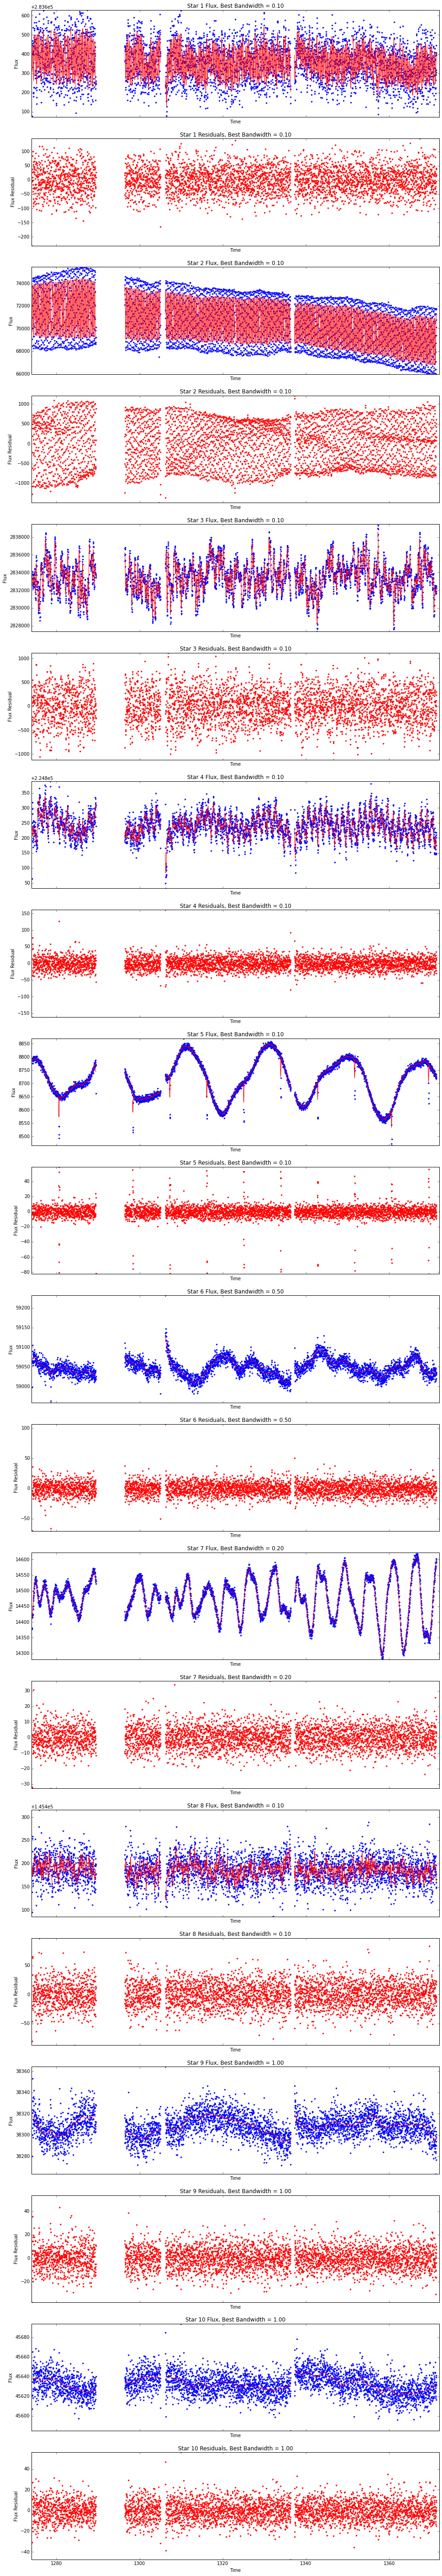

In [12]:
# Plot flux, regression fit, and residuals
Ws = generate_w([.1,.2,.5,.7,1],kernel=epanechinkov)

M = len(test_cases)
f,subplts = plt.subplots(M*2,1, sharex='col')
f.set_size_inches(16,M*10)
for i, (id,x,y) in enumerate(test_cases):
    res, h = best_kernel_regression(y,Ws,kernel=epanechinkov,test=True)
    
    # Fits
    subplts[2*i].set_title('Star %d Flux, Best Bandwidth = %.2f' % (i+1,h))
    subplts[2*i].set_xlabel('Time')
    subplts[2*i].set_ylabel('Flux')
    subplts[2*i].set_xlim(1274, 1372)
    subplts[2*i].set_ylim(np.nanmin(y,axis=0),np.nanmax(y,axis=0))
    subplts[2*i].plot(x,y,'b.',x,y-res,'r-')

    # Residuals
    subplts[2*i+1].set_title('Star %d Residuals, Best Bandwidth = %.2f' % (i+1,h))
    subplts[2*i+1].set_xlabel('Time')
    subplts[2*i+1].set_ylabel('Flux Residual')
    subplts[2*i+1].set_xlim(1274, 1372)
    subplts[2*i+1].set_ylim(np.nanmin(res,axis=0),np.nanmax(res,axis=0))
    subplts[2*i+1].plot(x,res,'r.')
plt.show()

#### (c) Standardize the residual so that it has zero mean and variance one using MAD

In [13]:
def stand_residual(res):
    '''Standardizes residuals, with standard deviation calculated using maximum absolute deviation (MAD)'''
    mean   = np.nanmean(res)
    median = np.nanmedian(res)
    sd     = 1.4826*np.nanmedian(np.abs(res-median))
    return (res-mean)/sd

#### (d) Compute the universal threshold

In [14]:
def universal_threshold(st_res):
    ''' Thresholds residuals using universal threshold '''
    n    = len(st_res) - np.sum(np.isnan(st_res))
    beta = np.sqrt(2*np.log(n))
    return np.where(np.nan_to_num(st_res)< -beta,st_res,0)

#### (e) Compute the l1 norm of the thresholded residuals
This is where I run all the steps together

In [33]:
# No need to regenerate weight vectors each time
Ws = generate_w([.1,.2,.5,.7,1],kernel=epanechinkov)

# Score all of the stars for the likelihood or a planet or binary star
scored_lc = lc.map(lambda (id,time,flux): (id,best_kernel_regression(flux,Ws)))\
    .map(lambda (id,res): (id,stand_residual(res)))\
    .map(lambda (id,res): (id,universal_threshold(res)))\
    .map(lambda (id,th_res): (id,nplin.norm(th_res,1),th_res))\
    .cache()

Now, rank all the planets by the L1 norm of the residuals and see the precision recall curve

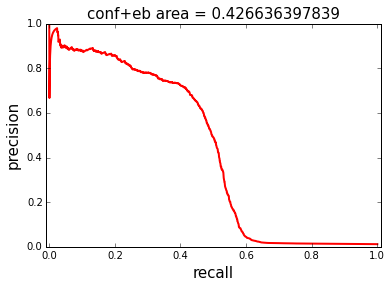

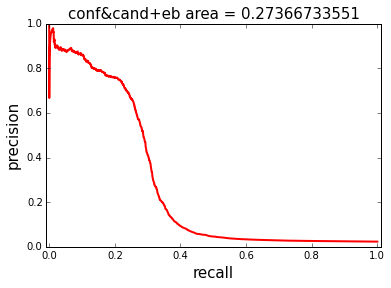

(0.4266364, 0.27366734)

In [39]:
# Sort and return keys by the norm
ranking = scored_lc.map(lambda (id,norm,res): (id,norm))\
    .sortBy(itemgetter(1),ascending=False)\
    .keys().collect()
    
prcurve_1(ranking)